In [ ]:
#model loading base
!pip install -q accelerate transformers datasets peft bitsandbytes pillow

from huggingface_hub import login
import torch
import gc
import os

HF_TOKEN = input("Enter your Hugging Face token: ").strip()
login(HF_TOKEN)

!rm -rf ~/.cache/huggingface/datasets/*
gc.collect()
torch.cuda.empty_cache()

from transformers import AutoProcessor, AutoModelForImageTextToText
from PIL import Image

model_id = "google/medgemma-4b-it"
base_model = AutoModelForImageTextToText.from_pretrained(model_id, torch_dtype=torch.bfloat16, device_map="auto")
processor = AutoProcessor.from_pretrained(model_id)
print("✅ Model loaded!")

In [ ]:
#finetune lora
from peft import LoraConfig, get_peft_model
lora_config = LoraConfig(r=4, lora_alpha=8, lora_dropout=0.05, bias="none", task_type="CAUSAL_LM",
                        target_modules=["q_proj", "v_proj"])
for p in model.vision_tower.parameters(): p.requires_grad = False
for p in model.multi_modal_projector.parameters(): p.requires_grad = False
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

from datasets import load_dataset

print("📥 Loading 200 samples...")
raw_dataset = load_dataset("BahaaEldin0/NIH-Chest-Xray-14", split="train", streaming=True)

dataset_list = []
for i, example in enumerate(raw_dataset):
    if i >= 200:
        break
    img = example['image'].convert("RGB").resize((128, 128))
    labels_list = example.get('Finding Labels', ['Normal'])
    label_str = ", ".join(labels_list) if isinstance(labels_list, list) else str(labels_list)

    dataset_list.append({'image': img, 'label': label_str})

    if i % 50 == 0:
        print(f"Loaded {i}...")
        gc.collect()

from datasets import Dataset
dataset = Dataset.from_list(dataset_list)
print(f"✅ {len(dataset)} samples")

del raw_dataset, dataset_list
gc.collect()

PROMPT_TEMPLATE = """Analyze this chest X-ray and provide:
1) Abnormalities
2) Diagnosis
3) Severity
4) Recommendations
Be concise."""

def preprocess(example):
    answer = f"1) {example['label']}. 2) {example['label']}. 3) Moderate. 4) Follow-up."

    messages = [
        {"role": "system", "content": [{"type": "text", "text": "You are an expert radiologist."}]},
        {"role": "user", "content": [{"type": "text", "text": PROMPT_TEMPLATE}, {"type": "image", "image": example['image']}]},
        {"role": "assistant", "content": [{"type": "text", "text": answer}]}
    ]

    inputs = processor.apply_chat_template(messages, add_generation_prompt=False, tokenize=True, return_tensors="pt", return_dict=True)
    labels = inputs["input_ids"].clone()

    # Flatten all tensors to 1D if needed
    result = {}
    for k, v in inputs.items():
        if isinstance(v, torch.Tensor):
            result[k] = v.squeeze(0)  # Remove batch dimension
        else:
            result[k] = v
    result["labels"] = labels.squeeze(0)

    del inputs, labels, messages
    return result

train_ds = dataset.map(preprocess, remove_columns=dataset.column_names, num_proc=1)
print("✅ Dataset ready:", len(train_ds))

del dataset
gc.collect()
torch.cuda.empty_cache()

from transformers import TrainingArguments, Trainer, DefaultDataCollator

training_args = TrainingArguments(
    output_dir="medgemma-xlora",
    num_train_epochs=1,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=2,
    learning_rate=2e-5,
    warmup_steps=5,
    logging_steps=10,
    save_steps=100,
    save_total_limit=1,
    bf16=True,
    remove_unused_columns=True,
    report_to=[],
    dataloader_num_workers=0,
    gradient_checkpointing=True,
    max_grad_norm=0.5
)


data_collator = DefaultDataCollator(return_tensors="pt")

trainer = Trainer(model=model, args=training_args, train_dataset=train_ds, data_collator=data_collator)

gc.collect()
torch.cuda.empty_cache()

print("🚀 Training...")
trainer.train()
trainer.save_model("medgemma-xlora")
processor.save_pretrained("medgemma-xlora")
print("✅ Complete!")

del trainer, train_ds
gc.collect()
torch.cuda.empty_cache()



In [ ]:
#load my model
!pip install -q accelerate transformers datasets peft bitsandbytes pillow
from huggingface_hub import login
import os
OUTPUT_DIR = "/content/drive/MyDrive/medgemma-xlora"
HF_TOKEN = input("Enter your Hugging Face token: ").strip()
login(HF_TOKEN)

from transformers import AutoProcessor, AutoModelForImageTextToText
from peft import PeftModel
import torch

model_id = "google/medgemma-4b-it"

print("🔄 Loading base model (PEFT-compatible mode)...")


base_model = AutoModelForImageTextToText.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True
).to("cuda")

print("🔄 Loading LoRA adapters...")
model = PeftModel.from_pretrained(base_model, OUTPUT_DIR)
model = model.to("cuda")


processor = AutoProcessor.from_pretrained(model_id)
print("✅ Model loaded successfully!")





📤 Upload your chest X-ray image (JPG, PNG, etc.)...


Saving CXR253_IM-1045-1001.png to CXR253_IM-1045-1001 (1).png
✅ Loaded image: CXR253_IM-1045-1001 (1).png

🔮 Generating diagnosis...

🎯 FINETUNED MODEL DIAGNOSIS:
Here's an analysis of the chest X-ray:

1.  **Abnormalities:**
    *   Small, round opacities are present in the right lung, likely representing granulomas or calcified nodules.
    *   The heart size appears normal.
    *   The mediastinum is unremarkable.
    *   The lungs are otherwise clear.

2.  **Diagnosis:**
    *   The most likely diagnosis is **pulmonary granulomas or calcified nodules** in the right lung.

3.  **Severity:**
    *   The abnormalities are likely benign and not causing significant symptoms.

4.  **Recommendations:**
    *   Follow-up chest X-ray in 6 months to monitor for any changes in the size or number of the opacities.
    *   Consider further evaluation (e.g., CT scan) if there is any clinical concern or if the opacities change in size or appearance.


✅ INFERENCE COMPLETE!

📸 Image analyzed:


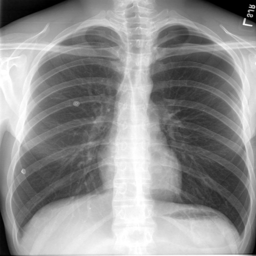

In [6]:
#test
from google.colab import files
from PIL import Image
from io import BytesIO

PROMPT_TEMPLATE = """Analyze this chest X-ray and provide:
1) Abnormalities
2) Diagnosis
3) Severity
4) Recommendations
Be concise."""

print("\n📤 Upload your chest X-ray image (JPG, PNG, etc.)...")
uploaded = files.upload()

# Get the uploaded file
filename = list(uploaded.keys())[0]
sample_img = Image.open(filename).convert("RGB").resize((128, 128))
print(f"✅ Loaded image: {filename}")

messages = [
    {"role": "system", "content": [{"type": "text", "text": "You are an expert radiologist."}]},
    {"role": "user", "content": [
        {"type": "text", "text": PROMPT_TEMPLATE},
        {"type": "image", "image": sample_img}
    ]}
]

inputs = processor.apply_chat_template(
    messages,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt"
).to("cuda", dtype=torch.bfloat16)

input_len = inputs["input_ids"].shape[-1]

print("\n🔮 Generating diagnosis...")
with torch.inference_mode():
    generation = model.generate(
        **inputs,
        max_new_tokens=600,
        do_sample=False,
        temperature=None,
        top_p=None
    )[0][input_len:]

result = processor.decode(generation, skip_special_tokens=True)

print("\n" + "="*70)
print("🎯 FINETUNED MODEL DIAGNOSIS:")
print("="*70)
print(result)
print("="*70)
print("\n✅ INFERENCE COMPLETE!")

# Display the image that was analyzed
from IPython.display import display
print("\n📸 Image analyzed:")
display(Image.open(filename).resize((256, 256)))